**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Importing Skin Cancer Data**


**Importing all the important libraries**

In [48]:
#!pip install tensorflow-gpu==2.4

In [49]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

In [50]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [51]:
root_path = "/content/gdrive/MyDrive/ColabNotebooks/CNN/CNN_assignment"
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [52]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2245
118


**Create a dataset**

Define some parameters for the loader:

In [53]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [54]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11245 files belonging to 9 classes.
Using 8996 files for training.


In [55]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11245 files belonging to 9 classes.
Using 2249 files for validation.


In [56]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [57]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Visualize the data**

create a code to visualize one instance of all the nine classes present in the dataset

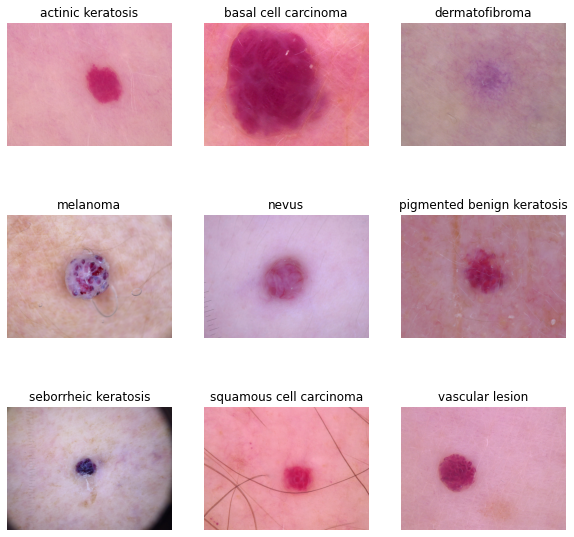

In [58]:
import matplotlib.pyplot as plt
import cv2

plt.figure(figsize=(10,10))
for x in class_names:
  filename = list(data_dir_train.glob(x+'/*.jpg'))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(PIL.Image.open(filename[i]))
  plt.title(class_names[i])
  plt.axis("off")


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [59]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create the model**

Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [60]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

**Compile the model**

Choose an appropirate optimiser and loss function for model training

In [61]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 129600)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

**Train the model**

In [63]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
282/282 [==============================] - 97s 124ms/step - loss: 2.6419 - accuracy: 0.2088 - val_loss: 1.4557 - val_accuracy: 0.4331
Epoch 2/20
282/282 [==============================] - 16s 56ms/step - loss: 1.3949 - accuracy: 0.4670 - val_loss: 1.2310 - val_accuracy: 0.5394
Epoch 3/20
282/282 [==============================] - 16s 56ms/step - loss: 1.1024 - accuracy: 0.6005 - val_loss: 1.1743 - val_accuracy: 0.5696
Epoch 4/20
282/282 [==============================] - 16s 56ms/step - loss: 0.8930 - accuracy: 0.6839 - val_loss: 0.8971 - val_accuracy: 0.6968
Epoch 5/20
282/282 [==============================] - 16s 56ms/step - loss: 0.7018 - accuracy: 0.7556 - val_loss: 0.8694 - val_accuracy: 0.6999
Epoch 6/20
282/282 [==============================] - 16s 56ms/step - loss: 0.5599 - accuracy: 0.8055 - val_loss: 0.7587 - val_accuracy: 0.7701
Epoch 7/20
282/282 [==============================] - 16s 56ms/step - loss: 0.4751 - accuracy: 0.8487 - val_loss: 0.7518 - val_accuracy

**Visualizing training results**

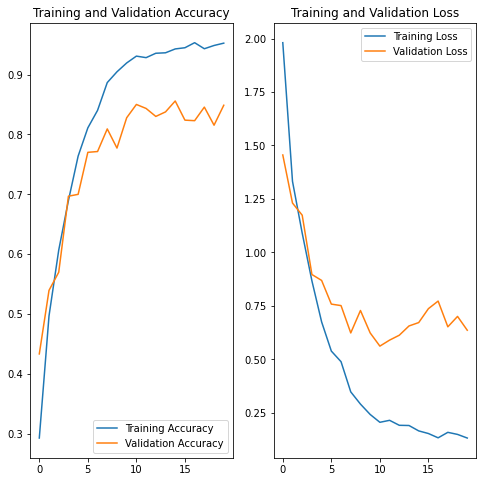

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Model Overfit or Underfit?**

The train accrucay is high whereas validation accuracy is comparatively very low clearly states that the model is Overfitting.

**choose an appropriate data augumentation strategy**

In [65]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3), seed=123),
    layers.experimental.preprocessing.RandomRotation(0.1, seed=123),
    layers.experimental.preprocessing.RandomZoom(0.1, seed=123),
  ]
)

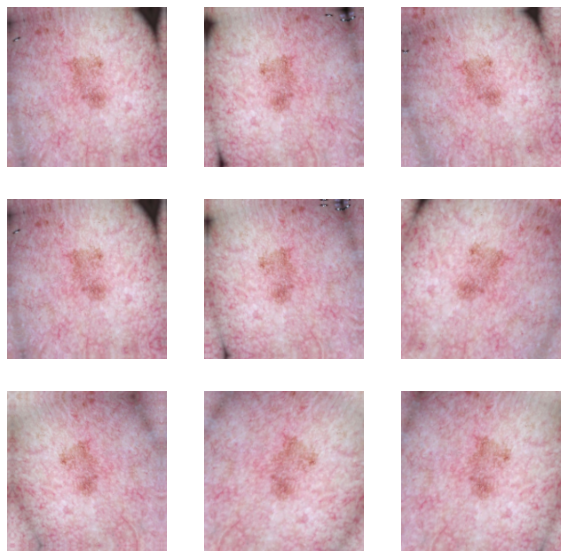

In [66]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [67]:
model2 = Sequential()
model2.add(data_augmentation)
model2.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model2.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model2.add(layers.Dropout(0.2))
model2.add(layers.MaxPooling2D())
model2.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model2.add(layers.MaxPooling2D())
model2.add(layers.Dropout(0.2))
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(9, activation='softmax'))

**Compiling the model**

In [68]:
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Training the model**

In [69]:
## Your code goes here, note: train your model for 20 epochs

history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
282/282 [==============================] - 24s 83ms/step - loss: 2.0768 - accuracy: 0.2377 - val_loss: 1.4485 - val_accuracy: 0.4566
Epoch 2/20
282/282 [==============================] - 23s 82ms/step - loss: 1.4204 - accuracy: 0.4524 - val_loss: 1.3223 - val_accuracy: 0.5047
Epoch 3/20
282/282 [==============================] - 23s 82ms/step - loss: 1.3106 - accuracy: 0.4908 - val_loss: 1.2503 - val_accuracy: 0.5411
Epoch 4/20
282/282 [==============================] - 23s 82ms/step - loss: 1.1958 - accuracy: 0.5378 - val_loss: 1.0999 - val_accuracy: 0.5945
Epoch 5/20
282/282 [==============================] - 23s 81ms/step - loss: 1.1161 - accuracy: 0.5745 - val_loss: 1.0523 - val_accuracy: 0.6069
Epoch 6/20
282/282 [==============================] - 23s 81ms/step - loss: 1.0167 - accuracy: 0.6082 - val_loss: 0.9605 - val_accuracy: 0.6510
Epoch 7/20
282/282 [==============================] - 23s 82ms/step - loss: 0.9315 - accuracy: 0.6481 - val_loss: 0.9454 - val_accuracy:

**Visualizing the results**

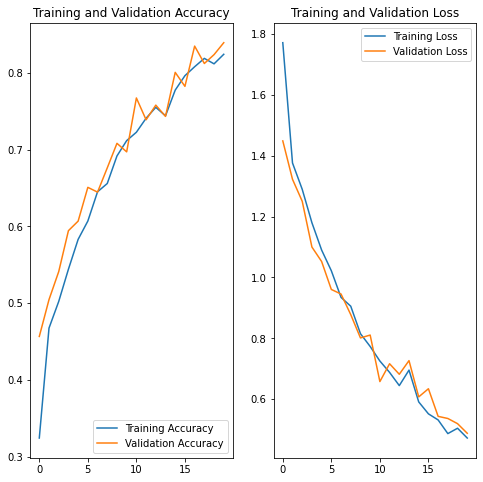

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?**

*The model is not overfitting now but accuracy is quite low, we need to increase the accuracy. This is due to class imbalance , so will try to balance our dataset and re train our model to see the results.*

**Find the distribution of classes in the training dataset.**

**Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [71]:

path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list[0]

lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list[0]

dataframe_dict_new = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      444
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64


**Which class has the least number of samples?**    *Seborrheic Keratosis* 

**Which classes dominate the data in terms proportionate number of samples?**     *Pigmented Benign Keratosis*

**Todo:** Rectify the class imbalance

**Context:** You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [72]:
!pip install Augmentor

In [73]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset)+"/"+str(i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/ColabNotebooks/CNN/CNN_assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9AB7B12DD0>: 100%|██████████| 500/500 [00:25<00:00, 19.32 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/ColabNotebooks/CNN/CNN_assignment/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9AAE5F2050>: 100%|██████████| 500/500 [00:25<00:00, 19.33 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/ColabNotebooks/CNN/CNN_assignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9B45974090>: 100%|██████████| 500/500 [00:27<00:00, 18.12 Samples/s]


Initialised with 444 image(s) found.
Output directory set to /content/gdrive/MyDrive/ColabNotebooks/CNN/CNN_assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F9AB17019D0>: 100%|██████████| 500/500 [02:02<00:00,  4.08 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/ColabNotebooks/CNN/CNN_assignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F9B4599CCD0>: 100%|██████████| 500/500 [01:35<00:00,  5.22 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/ColabNotebooks/CNN/CNN_assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9B45E58290>: 100%|██████████| 500/500 [00:25<00:00, 19.41 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/ColabNotebooks/CNN/CNN_assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9B45A1B790>: 100%|██████████| 500/500 [00:51<00:00,  9.74 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/ColabNotebooks/CNN/CNN_assignment/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9B45FFBF50>: 100%|██████████| 500/500 [00:23<00:00, 21.70 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/ColabNotebooks/CNN/CNN_assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9B45A1B790>: 100%|██████████| 500/500 [00:22<00:00, 22.03 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images

In [74]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

13500


**Lets see the distribution of augmented data after adding new images to the original training data.**

In [75]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[0]

'/content/gdrive/MyDrive/ColabNotebooks/CNN/CNN_assignment/Train/vascular lesion/output/vascular lesion_original_ISIC_0029404.jpg_dce4b775-31a7-499b-89fd-a276cd8ed02b.jpg'

In [76]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[0]

'vascular lesion'

In [77]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [78]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [79]:
new_df['Label'].value_counts()

pigmented benign keratosis    1962
melanoma                      1944
basal cell carcinoma          1876
nevus                         1857
squamous cell carcinoma       1681
vascular lesion               1639
actinic keratosis             1614
dermatofibroma                1595
seborrheic keratosis          1577
Name: Label, dtype: int64

So, now we have added more than 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

**Train the model on the data created using Augmentor**

In [80]:
batch_size = 32
img_height = 180
img_width = 180

 **Create a training dataset**

In [81]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15745 files belonging to 9 classes.
Using 12596 files for training.


**Create a validation dataset**

In [82]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15745 files belonging to 9 classes.
Using 3149 files for validation.


**Create your model (to include normalization)**

In [83]:
## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [84]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.91402805


In [85]:
model3 = Sequential()
model3.add(data_augmentation)
model3.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model3.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model3.add(layers.Dropout(0.2))
model3.add(layers.MaxPooling2D())
model3.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.Dropout(0.2))
model3.add(layers.Flatten())
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(9, activation='softmax'))

**Compile your model (Choose optimizer and loss function appropriately)**

In [86]:
## your code goes here
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [87]:
model3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_7 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 90, 90, 64)        18496     
_________________________________________________________________
dropout_6 (Dropout)          (None, 90, 90, 64)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 45, 45, 64)       

**Train your model**

In [88]:
epochs = 30

history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
394/394 [==============================] - 56s 139ms/step - loss: 2.2112 - accuracy: 0.2392 - val_loss: 1.4302 - val_accuracy: 0.4621
Epoch 2/30
394/394 [==============================] - 32s 82ms/step - loss: 1.3927 - accuracy: 0.4667 - val_loss: 1.2332 - val_accuracy: 0.5487
Epoch 3/30
394/394 [==============================] - 32s 82ms/step - loss: 1.2514 - accuracy: 0.5170 - val_loss: 1.2426 - val_accuracy: 0.5364
Epoch 4/30
394/394 [==============================] - 32s 82ms/step - loss: 1.1860 - accuracy: 0.5431 - val_loss: 1.1255 - val_accuracy: 0.5989
Epoch 5/30
394/394 [==============================] - 32s 82ms/step - loss: 1.0684 - accuracy: 0.5955 - val_loss: 1.1578 - val_accuracy: 0.5599
Epoch 6/30
394/394 [==============================] - 32s 82ms/step - loss: 0.9667 - accuracy: 0.6409 - val_loss: 0.8782 - val_accuracy: 0.6996
Epoch 7/30
394/394 [==============================] - 32s 82ms/step - loss: 0.8820 - accuracy: 0.6725 - val_loss: 0.7952 - val_accuracy

**Visualize the model results**

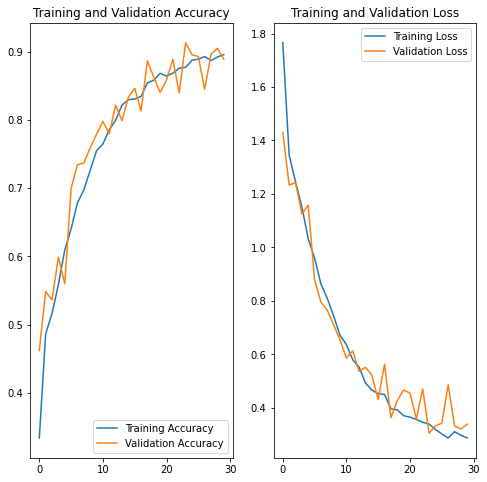

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?**

- Yes class Reblance helps, we got a good model with validation accuracy is boosted and training accuracy is also very good.
